In [141]:
# Choose style for the plots
plt.style.available
matplotlib.style.use('seaborn-deep')

In [81]:
# Install all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
% matplotlib inline
from sklearn.neighbors.kde import KernelDensity

In [82]:
# Load the data
data = pd.read_csv("/Users/ritakurban/Downloads/transactions.csv")
print data.head()

        Date    Amount
0  25May2016  54241.35
1  29May2017  54008.83
2  30Jun2017  54008.82
3  05Jan2017  52704.37
4  23Feb2017  52704.36


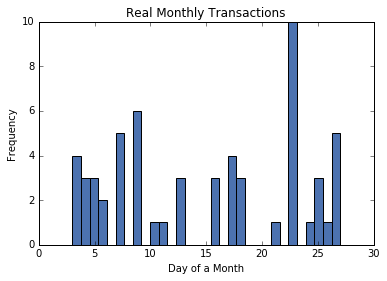

In [139]:
# Extract month and year
data['month_year'] = [s[2:] for s in data.Date] 
# Extract day of month
data['day'] = [int(s[:2]) for s in data.Date] 
# Shift data and log to ensure we don't take a log of a negative number.
data['log'] = np.log(data.Amount - min(data.Amount) + 1) 
data.head()

# Looking closely at one month of transactions
plt.hist(data[data.month_year == "Jan2017"].day, bins = 31)
plt.title("Real Monthly Transactions")
plt.xlabel("Day of a Month")
plt.ylabel('Frequency')
plt.show()

As you can see from the plot, this bank doesn't process transactions on certain days (supposedly weekends.) This pattern appears in other months as well. In this paper, I'm not explicitly estimating a distribution over weekdays, so let's see if the model will be able to account for these irregularities.

In [113]:
# Extract counts of monthly transactions 
monthly_count = data.groupby([data['month_year']]).agg({'count'})
counts = monthly_count.Amount.as_matrix().reshape(-1, 1)

In [132]:
def density(input_data, bandwidth, title=None,  kernel = "gaussian"):
    """ Builds density models.
    Inputs:
        
        input_data (matrix) The distribution we want to estimate.
        
        bandwidth (integer) Determines the smoothness of the line.
        
        title (string) A title of the plot if needed.
        
        kernel (string) The name of the kernel to use.
    
    Outputs:
        
        A graph of the density distribution.
    
    """
    # Create an estimation
    X_plot = np.linspace(min(input_data), max(input_data),
                         1000)[:, np.newaxis]
    kde = KernelDensity(kernel = kernel, bandwidth=bandwidth).fit(
        input_data)
    log_dens = kde.score_samples(X_plot)
    
    # Plot the distribution
    plt.hist(input_data, normed=True, bins=15)
    plt.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = gaussian")
    plt.title(title)
    plt.legend(loc='upper right')
    plt.xlabel(title)
    plt.ylabel(r'Frequency')
    plt.plot(input_data, -0.0005 - 0.001 * 
             np.random.random(len(input_data)), '+k')
    plt.show()
    return kde


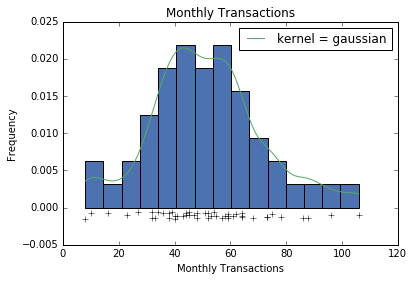

In [133]:
# Estimate density of number of transactions per month
month_year = density(counts, 5, "Monthly Transactions")

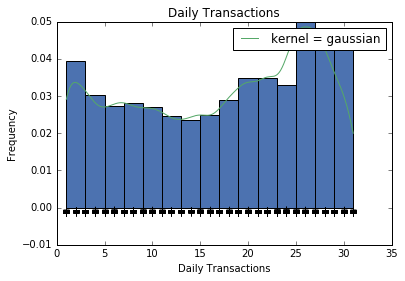

In [134]:
# Estimate density of number of transactions per day of a month
daily = data.day.as_matrix().reshape(-1, 1)
day_month = density(daily, 1, "Daily Transactions")

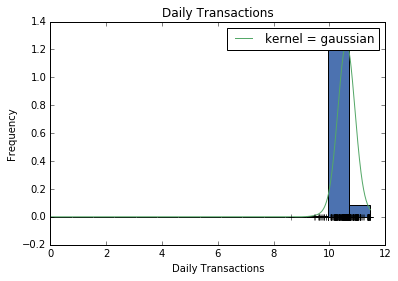

In [135]:
# Estimate density of transaction sizes
transaction_size = data.log.as_matrix().reshape(-1, 1)
amount = density(transaction_size, 0.3, "Daily Transactions")

In [50]:
def fake_data(month_year, day_month, amount, n = 1):
    """Creates fake data with the help of the distributions 
    calculated above.
    
    Inputs:
    
        month_year A number of monthly transactions.
        
        day_month A distribution of daily transactions in a month.
        
        amount The amount of money.
        
        n (integer) A multiplication factor for cases when
        I need to produce more data.
  
  Outputs:
    
        A dataframe of fake data with days and transaction amounts.
        
    """ 
    total = int(month_year.sample()) * n
    # I've found out that the Gausian kernel generates days
    # that are sometimes smaller than 1 or bigger than 31.
    # To account for this, I generate more values and subtract 
    # inappropriate ones. 
    days = day_month.sample(total+20).astype(int).reshape(1, -1)[0]
    days = days[days <= 31]
    days = days [days > 0]
    days = days[:total]
    # I add the min loan amount to account for the shift
    # I've done earlier
    amounts = np.exp(amount.sample(total).reshape(1,-1)[0]) + 
                                min(data.Amount) + 1
    
    return pd.DataFrame(list(zip(days, amounts)), 
    columns=["Day", "Amount"]).sort_values("Day").reset_index(drop=True)

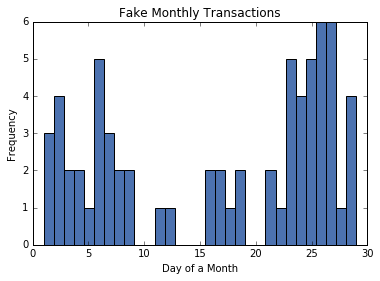

In [140]:
# Explore the distribution of fake data
fake_month = fake_data(month_year, day_month, amount)
plt.hist(fake_month.Day, bins = 31)
plt.title("Fake Monthly Transactions")
plt.xlabel("Day of a Month")
plt.ylabel('Frequency')
plt.show()

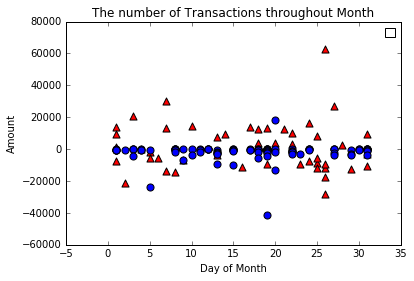

In [112]:
# Produce a lot of fake data
x = list(fake_month.Day)
y = list(fake_month.Amount)
# Plot fake and real data to visualize their distributions
plt.scatter(x=x, y=y,  marker='^', c = "r", s =50)
plt.legend()
plt.scatter(x = data[data.month_year == "Dec2014"].day, y = 
    data[data.month_year == "Dec2014"].Amount, c = "b", s =50)
plt.xlabel("Day of Month")
plt.ylabel("Amount")
plt.title("The number of Transactions throughout Month")
plt.show()

As you can see from the plots above, fake data and real data have similar but not identical distributions. Red triangles (fake data) have a higher variance than blue circles (actual data) which probably happens because our dataset is not very big. Even though these data seem to be a good approximation of monthly transactions, it would still be possible for a forensic accountant to find and determine that this set of transactions is fraudulent. Why does it happen?

From the first histogram, it is evident that the model cannot account for the bank's days-off which I've described above. It is not a surprise that the model failed to identify this pattern since it must be estimated by a distribution I haven't estimated (over weekdays). To solve this problem, it would be necessary to lookup the weekdays in the calendar and estimate the forth distribution. Otherwise, it would be easy for a specialist to understand that these data are fraudulent since some transactions are processed on days-off.

The model correctly estimates the average number of transactions in a month, the number o transactions per day and the amount of these transactions. However, there are definitely some other factors that might be particularly important. For example, there might be the case that whether the amount of the transaction is positive or negative depends on the weekday or a day of the month. Let's say, people usually spend money during the weekend and get their paychecks on the 25th of every month. It might also be the case that they pay their loans and rent on specific days. Unfortunately, the model fails to account for such cases since it's not able to associate a day with a specific amount. 

The Benford distribution is [0, .301, .176, .125, .097, .079, .067, .058, .051, .046].

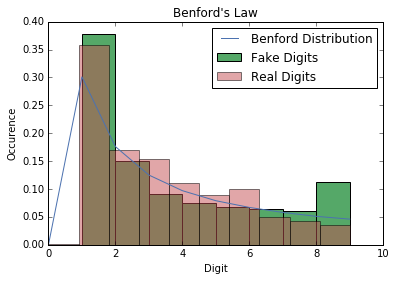

In [131]:
# An estimation of Benford distribution
benford_dist = [0, .301, .176, .125, .097, 
                .079, .067, .058, .051, .046]
digits = np.array(range(10))

fake_month = fake_data(month_year, day_month, amount, n = 10000)

real_first_digits = [int(str(abs(x))[0]) for x in data.Amount]
fake_first_digits = [int(str(abs(x))[0]) for x in fake_month.Amount]

# Plot them all together 
plt.plot(digits, benford_dist, label="Benford Distribution")
plt.hist(fake_first_digits, label="Fake Digits", 
         normed=True, bins=9)
plt.hist(real_first_digits, label="Real Digits", bins=10, 
         normed=True, alpha=.5)
plt.title("Benford's Law")
plt.xlabel('Digit')
plt.ylabel('Occurence')
plt.legend()
plt.show()

The graph shows that both datasets follow the Benford distribution pretty well. However, my fake data are still a little bit worse than the real ones. Fake data generates a higher number of transactions that start with digit "1" and underestimates the number of transactions that start with 2-6.